In [1]:
#pip install scikit-learn
#pip install pandas

# Main imports pandas and sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from gensim.models import word2vec

# We may need to do some web scraping to get the review text
import urllib.request
from bs4 import BeautifulSoup

#Other imports
import time
import sys
from os import system
from IPython.display import clear_output

# Load in data
### There are a few steps to getting clean data
- Read data from kaggle into dataframes
- Get rid of unecessary features of the data
- (For game spot data) get the review text from the web
- Clean data using dropna

## Read in data from csv

In [2]:
# download dataset at: https://www.kaggle.com/datasets/joyshil0599/multi-decade-video-game-review-dataset
GAME_SPOT_DATASET_PATH = "data/game_spot_data.csv"
# downoad dataset at: https://www.kaggle.com/datasets/andrewmvd/steam-reviews
STEAM_DATASET_PATH = 'data/steam_data.csv'
# download dataset at: https://www.kaggle.com/datasets/noahx1/elden-ring-steam-reviews
ELDEN_RING_DATASET_PATH = "data/elden_ring_data.csv"

# Read in the datasets
game_spot_data = pd.read_csv(GAME_SPOT_DATASET_PATH)
steam_data = pd.read_csv(STEAM_DATASET_PATH)
elden_ring_data = pd.read_csv(ELDEN_RING_DATASET_PATH)

In [3]:
# Lets only keep the columns we want
game_spot_cols = ['Review link','Rating/10']
if('Review' in game_spot_data.columns):
    game_spot_cols.append('Review')
steam_cols = ['review_text','review_score']
elden_ring_cols = ['voted_up','review']

game_spot_data = game_spot_data[game_spot_cols]
steam_data = steam_data[steam_cols]
elden_ring_data = elden_ring_data[elden_ring_cols]

# Lets rename some columns and change them to be consistant
steam_data['review_score'].replace({1:True,-1:False},inplace=True)
steam_data.rename(columns={'review_score':'up_vote','review_text':'Review'}, inplace=True)
elden_ring_data.rename(columns={'voted_up':'up_vote','review':'Review'},inplace=True)

# Read in reviews from web (for game spot data)

In [4]:
# Now lets define how to get the text of the reviews from the web
def GetReviewsFromWeb():
    num_processed = 1
    prev_time = time.time()
    num_links = len(game_spot_data.index)
    check_interval = 5
    reviews = []
    failed_links = []
    for link in game_spot_data['Review link']:
        # Try to get the review text
        try:
            page = urllib.request.urlopen(link).read()
            page = BeautifulSoup(page)
            review = ""
            body = page.find(class_="article-body typography-format")
            paragraphs = body.find_all("p")
            if(len(paragraphs)==0):
                raise Exception('NO REVIEW TEXT FOUND')
            for p in paragraphs:
                review+=p.text+" "
            reviews.append(review)
        # If we could not get the review text
        except:
            reviews.append(None)
            failed_links.append(link)
        # Display progress
        num_processed = num_processed + 1
        if(num_processed % check_interval == 0):
            prediction = (time.time() - prev_time)/(check_interval) * (num_links-len(reviews))
            prev_time = time.time()
            system('cls')
            clear_output(wait=True)
            print(f"Reviews lost: {len(failed_links)}")
            print(f"processed: {num_processed} / {num_links}")
            print(f"Time left: {int(prediction)} s")  
    # Update dataframe and write to file
    game_spot_data['Review'] = reviews
    

In [5]:
# If gamespot data does not have review then we need to get it from the web
if(not 'Review' in game_spot_data.columns):
    GetReviewsFromWeb()
    game_spot_data.to_csv(GAME_SPOT_DATASET_PATH, index=False)

# Now lets define our classifications (Sentiment)

In [6]:
# We define 2 sentiments to classify
GOOD = 'Good'
BAD = 'Bad'

In [7]:
def GetSentimentFromRating(rating):
    if(rating is None):
        return None
    if(rating > 7):
        return GOOD
    if(rating > 0):
        return BAD

In [8]:
def GetSentimentFromUpVote(up_vote):
    if(up_vote):
        return GOOD
    else:
        return BAD

In [9]:
def AddSentiment(df):
    s = []
    if('Rating/10' in df.columns):
        for rating in game_spot_data['Rating/10'].to_list():
            s.append(GetSentimentFromRating(rating))
    elif('up_vote' in df.columns):
        for upvote in df['up_vote'].to_list():
            s.append(GetSentimentFromUpVote(upvote))
    else:
        raise Exception(f"No column in dataframe to use for sentiment! {df.columns}")
    df['Sentiment'] = s
    print("DATA DISTRIBUTION:")
    SENTIMENTS = df['Sentiment'].unique()
    for s in SENTIMENTS:
        print(f"{s}: {sum(1 for i in df['Sentiment'] if i == s)}")

In [10]:
AddSentiment(game_spot_data)
AddSentiment(steam_data)
AddSentiment(elden_ring_data)

DATA DISTRIBUTION:
Bad: 6743
Good: 5823
DATA DISTRIBUTION:
Good: 5260420
Bad: 1156686
DATA DISTRIBUTION:
Good: 9201
Bad: 593


# Clean data

In [11]:
def CleanData(df):
    # Now lets finish cleaning the data by dropping any invalid rows
    old_size = df.shape
    df.dropna(inplace=True)
    new_size = df.shape
    print("Dropping rows")
    print(f"Old count: {old_size[0]}")
    print(f"New count: {new_size[0]}")
    print(f"Removed {old_size[0]-new_size[0]} rows.")
    

In [12]:
CleanData(game_spot_data)
CleanData(steam_data)
CleanData(elden_ring_data)

Dropping rows
Old count: 12566
New count: 12566
Removed 0 rows.
Dropping rows
Old count: 6417106
New count: 6409801
Removed 7305 rows.
Dropping rows
Old count: 9794
New count: 9765
Removed 29 rows.


# Now we split our data

In [13]:
def SplitData(df,test_split=0.3):
    #split datasets
    X = df['Review']
    y = df['Sentiment'] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state=1) 
    X_train.to_list()
    X_test = X_test.to_list()
    y_train = y_train.to_list()
    y_test = y_test.to_list()
    return X_train, X_test, y_train, y_test 

In [14]:
game_spot_X_train, game_spot_X_test, game_spot_y_train, game_spot_y_test = SplitData(game_spot_data)
steam_X_train, steam_X_test, steam_y_train, steam_y_test = SplitData(steam_data)
elden_ring_X_train, elden_ring_X_test, elden_ring_y_train, elden_ring_y_test = SplitData(elden_ring_data)

## Vectorize the data
We will be using a method called **Term Frequency and Inverse Document Frequency (TF-IDF)**. 
Here is how it works: https://medium.com/@vasista/preparing-the-text-data-with-scikit-learn-b31a3df567e

#### sklearn supplies an easy way to implement this

In [15]:
def CreateVectorizerCount(X_train):
    vectorizer = CountVectorizer()
    train_vectors = vectorizer.fit_transform(X_train)
    return vectorizer, train_vectors
def CreateVectorizerTFID(X_train):
    vectorizer = TfidfVectorizer(min_df = 5,max_df = 0.8,sublinear_tf = True,use_idf = True)
    train_vectors = vectorizer.fit_transform(X_train)
    return vectorizer, train_vectors
def CreateVectorizerHashing(X_train):
    vectorizer = HashingVectorizer()
    train_vectors = vectorizer.fit_transform(X_train)
    return vectorizer, train_vectors
def CreateVectorizerWord2Vec(X_train):
    vectorizer = TfidfVectorizer(min_df = 5,max_df = 0.8,sublinear_tf = True,use_idf = True)
    train_vectors = vectorizer.fit_transform(X_train)
    return vectorizer, train_vectors

# Creating svm
#### Helpful link to understand how this works:
- https://medium.com/@vasista/sentiment-analysis-using-svm-338d418e3ff1



In [50]:
def TestSVM(svm_linear, vectorizer, X_test, y_test): 
    print('Testing SVM ...')
    start_time = time.time()
    test_vectors = vectorizer.transform(X_test)
    prediction = svm_linear.predict(test_vectors)
    end_time = time.time()
    print(f"Tested SVM in {end_time-start_time} s")
    report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, prediction)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = svm_linear.classes_)
    cm_disp.plot()
    key = 'accuracy'
    cm_disp.ax_.set_title(f'{key}: {report[key]}\n')
    print(f'{key}: {report[key]}\n')
    return report

In [17]:
def CreateSVMCount(x_train, y_train):
    print('training SVM...')
    start_time = time.time()
    vectorizer, train_vectors = CreateVectorizerCount(x_train)
    svm_linear = svm.LinearSVC()
    start_time = time.time()
    svm_linear.fit(train_vectors, y_train)
    end_time = time.time()
    print(f"Trained SVM in {end_time-start_time} s")
    return svm_linear, vectorizer
def CreateSVMTFID(x_train, y_train):
    print('training SVM...')
    start_time = time.time()
    vectorizer, train_vectors = CreateVectorizerTFID(x_train)
    svm_linear = svm.LinearSVC()
    start_time = time.time()
    svm_linear.fit(train_vectors, y_train)
    end_time = time.time()
    print(f"Trained SVM in {end_time-start_time} s")
    return svm_linear, vectorizer
def CreateSVMHashing(x_train, y_train):
    print('training SVM...')
    start_time = time.time()
    vectorizer, train_vectors = CreateVectorizerHashing(x_train)
    svm_linear = svm.LinearSVC(max_iter=10000)
    start_time = time.time()
    svm_linear.fit(train_vectors, y_train)
    end_time = time.time()
    print(f"Trained SVM in {end_time-start_time} s")
    return svm_linear, vectorizer
def CreateSVMWord2Vec(x_train, y_train):
    print('training SVM...')
    start_time = time.time()
    vectorizer, train_vectors = CreateVectorizerWord2Vec(x_train)
    svm_linear = svm.LinearSVC()
    start_time = time.time()
    svm_linear.fit(train_vectors, y_train)
    end_time = time.time()
    print(f"Trained SVM in {end_time-start_time} s")
    return svm_linear, vectorizer

# Train SVM with game spot data

In [18]:
game_spot_svm_Count, game_spot_vectorizer_Count = CreateSVMCount(game_spot_X_train, game_spot_y_train)
game_spot_svm_TFID, game_spot_vectorizer_TFID = CreateSVMTFID(game_spot_X_train, game_spot_y_train)
game_spot_svm_Hashing, game_spot_vectorizer_Hashing = CreateSVMHashing(game_spot_X_train, game_spot_y_train)
#game_spot_svm_Count, game_spot_vectorizer_Count = CreateSVMCount(game_spot_X_train, game_spot_y_train)


training SVM...


C:\Users\sadze\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Trained SVM in 5.147579908370972 s
training SVM...
Trained SVM in 0.2988295555114746 s
training SVM...
Trained SVM in 0.704662561416626 s


### Test game_spot_svm on game_spot test data

Testing SVM ...
Tested SVM in 2.0530388355255127 s
accuracy: 0.7851458885941645

Testing SVM ...
Tested SVM in 2.11484432220459 s
accuracy: 0.8437665782493369

Testing SVM ...
Tested SVM in 1.8317198753356934 s
accuracy: 0.8177718832891246



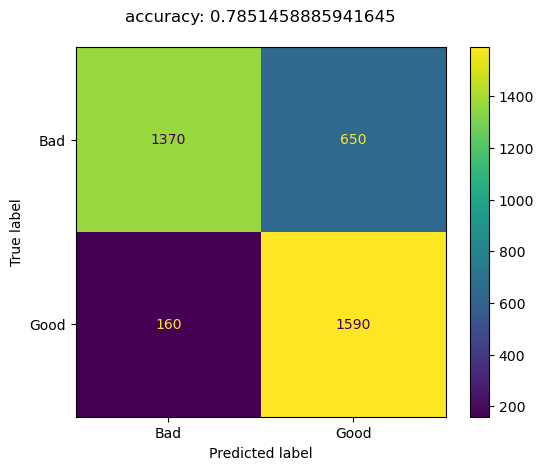

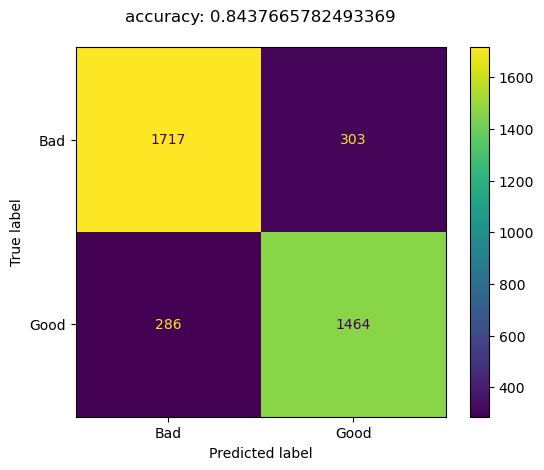

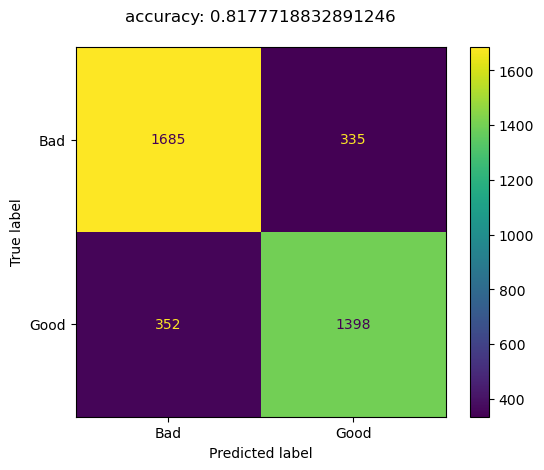

In [53]:
report = TestSVM(game_spot_svm_Count, game_spot_vectorizer_Count, game_spot_X_test, game_spot_y_test)
report = TestSVM(game_spot_svm_TFID, game_spot_vectorizer_TFID, game_spot_X_test, game_spot_y_test)
report = TestSVM(game_spot_svm_Hashing, game_spot_vectorizer_Hashing, game_spot_X_test, game_spot_y_test)

#report = TestSVM(game_spot_svm_TFID, game_spot_vectorizer_TFID, game_spot_X_test, game_spot_y_test)


### Test game_spot_svm on steam data

Testing SVM ...
Tested SVM in 48.982319355010986 s
accuracy: 0.5962091400620196

Testing SVM ...
Tested SVM in 48.58004570007324 s
accuracy: 0.28478356850262176

Testing SVM ...
Tested SVM in 41.96636986732483 s
accuracy: 0.2634828629687546



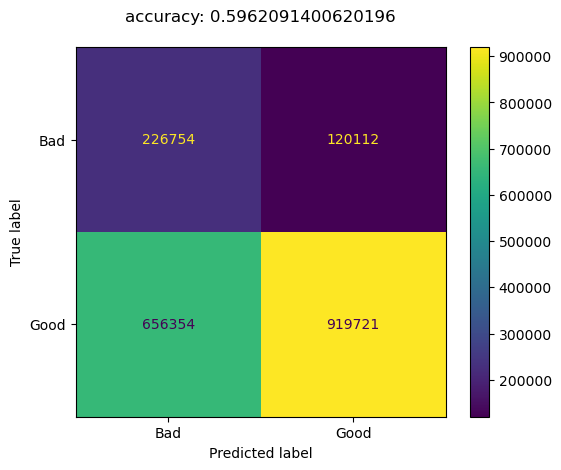

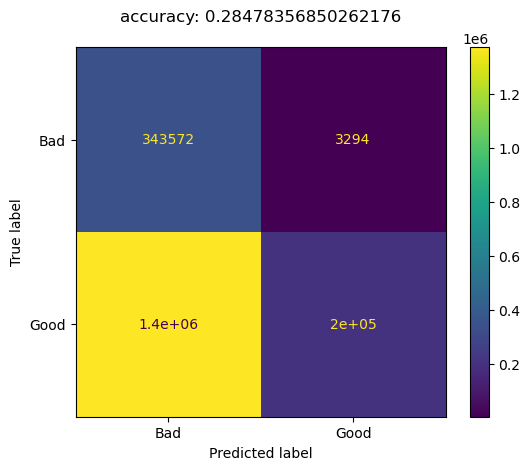

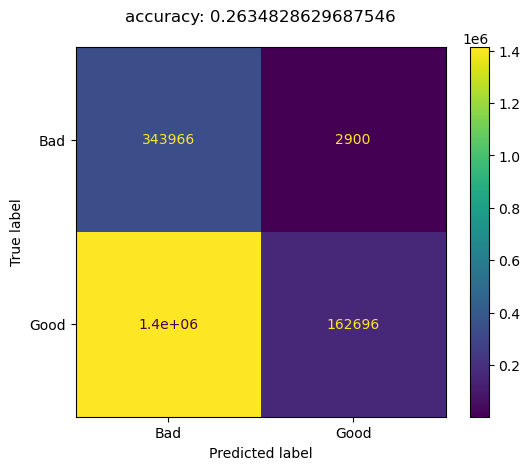

In [54]:
report = TestSVM(game_spot_svm_Count, game_spot_vectorizer_Count, steam_X_test, steam_y_test)
report = TestSVM(game_spot_svm_TFID, game_spot_vectorizer_TFID, steam_X_test, steam_y_test)
report = TestSVM(game_spot_svm_Hashing, game_spot_vectorizer_Hashing, steam_X_test, steam_y_test)

### Test game_spot_svm on elden ring data

Testing SVM ...
Tested SVM in 0.043024539947509766 s
accuracy: 0.3969283276450512

Testing SVM ...
Tested SVM in 0.04280996322631836 s
accuracy: 0.15802047781569967

Testing SVM ...
Tested SVM in 0.03455519676208496 s
accuracy: 0.11399317406143344



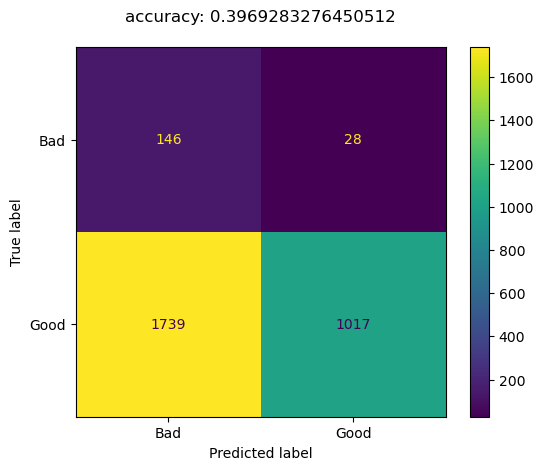

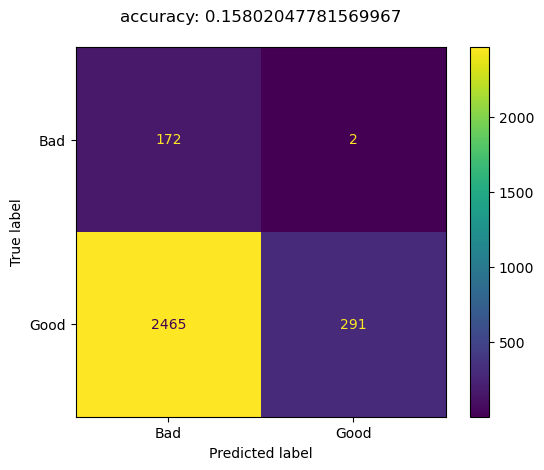

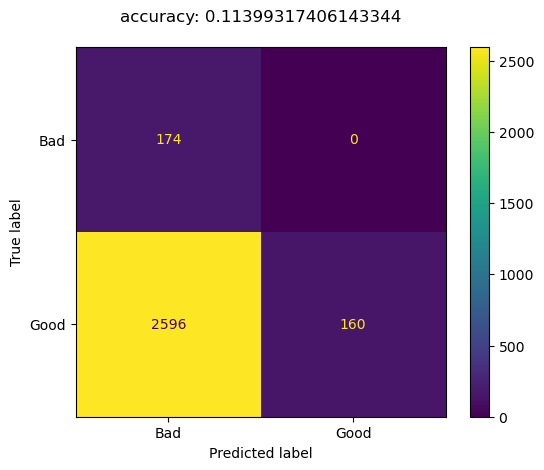

In [55]:
report = TestSVM(game_spot_svm_Count, game_spot_vectorizer_Count, elden_ring_X_test, elden_ring_y_test)
report = TestSVM(game_spot_svm_TFID, game_spot_vectorizer_TFID, elden_ring_X_test, elden_ring_y_test)
report = TestSVM(game_spot_svm_Hashing, game_spot_vectorizer_Hashing, elden_ring_X_test, elden_ring_y_test)

# Train SVM with elden ring data

In [22]:
elden_ring_svm_Count, elden_ring_vectorizer_Count = CreateSVMCount(elden_ring_X_train, elden_ring_y_train)
elden_ring_svm_TFID, elden_ring_vectorizer_TFID = CreateSVMTFID(elden_ring_X_train, elden_ring_y_train)
elden_ring_svm_Hashing, elden_ring_vectorizer_Hashing = CreateSVMHashing(elden_ring_X_train, elden_ring_y_train)

training SVM...
Trained SVM in 0.12268853187561035 s
training SVM...


C:\Users\sadze\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Trained SVM in 0.01250600814819336 s
training SVM...
Trained SVM in 0.021067142486572266 s


### Test elden_ring_svm on elden ring test data

Testing SVM ...
Tested SVM in 0.040586233139038086 s
accuracy: 0.9436860068259386

Testing SVM ...
Tested SVM in 0.03970789909362793 s
accuracy: 0.952901023890785

Testing SVM ...
Tested SVM in 0.035703420639038086 s
accuracy: 0.9508532423208191



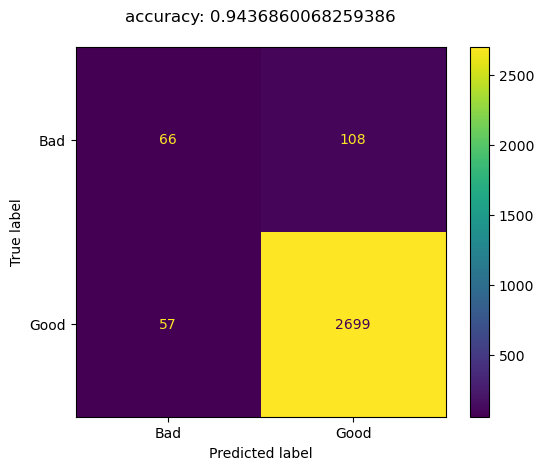

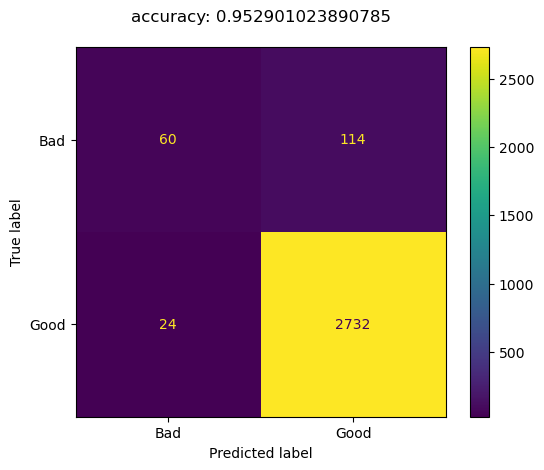

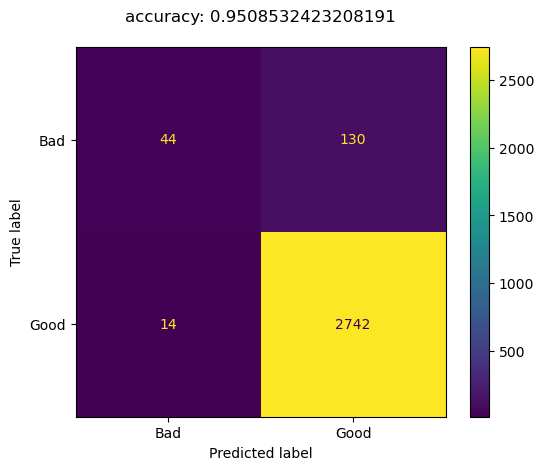

In [56]:
report = TestSVM(elden_ring_svm_Count, elden_ring_vectorizer_Count, elden_ring_X_test, elden_ring_y_test)
report = TestSVM(elden_ring_svm_TFID, elden_ring_vectorizer_TFID, elden_ring_X_test, elden_ring_y_test)
report = TestSVM(elden_ring_svm_Hashing, elden_ring_vectorizer_Hashing, elden_ring_X_test, elden_ring_y_test)

### Test elden_ring_svm on steam data

Testing SVM ...
Tested SVM in 46.958704710006714 s
accuracy: 0.8274580447346018

Testing SVM ...
Tested SVM in 46.87762951850891 s
accuracy: 0.8400325334994677

Testing SVM ...
Tested SVM in 40.61250853538513 s
accuracy: 0.8351779903803601



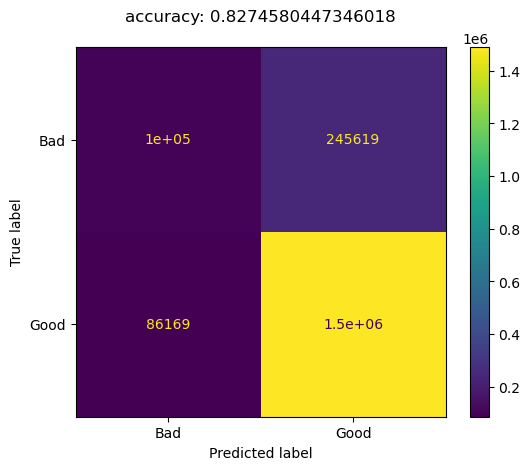

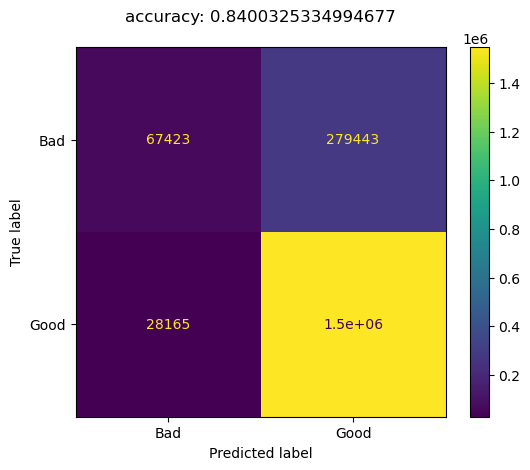

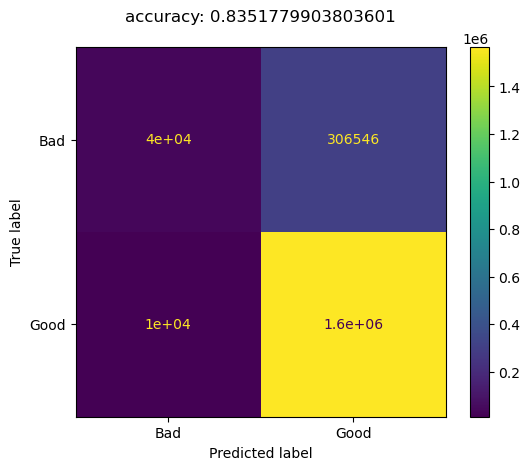

In [57]:
report = TestSVM(elden_ring_svm_Count, elden_ring_vectorizer_Count, steam_X_test, steam_y_test)
report = TestSVM(elden_ring_svm_TFID, elden_ring_vectorizer_TFID, steam_X_test, steam_y_test)
report = TestSVM(elden_ring_svm_Hashing, elden_ring_vectorizer_Hashing, steam_X_test, steam_y_test)

### Test elden_ring_svm on game spot data

Testing SVM ...
Tested SVM in 2.0094196796417236 s
accuracy: 0.5607427055702918

Testing SVM ...
Tested SVM in 1.8696417808532715 s
accuracy: 0.5872679045092838

Testing SVM ...
Tested SVM in 1.8266019821166992 s
accuracy: 0.4713527851458886



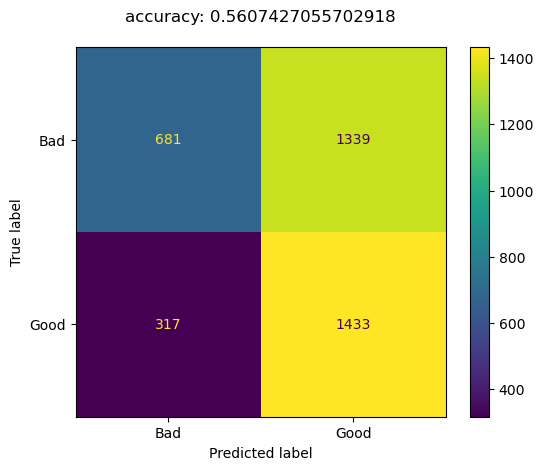

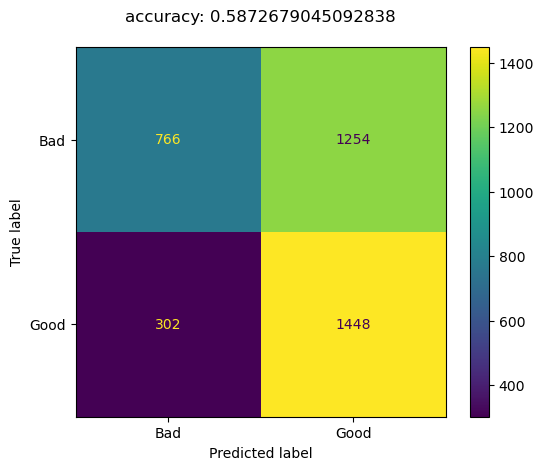

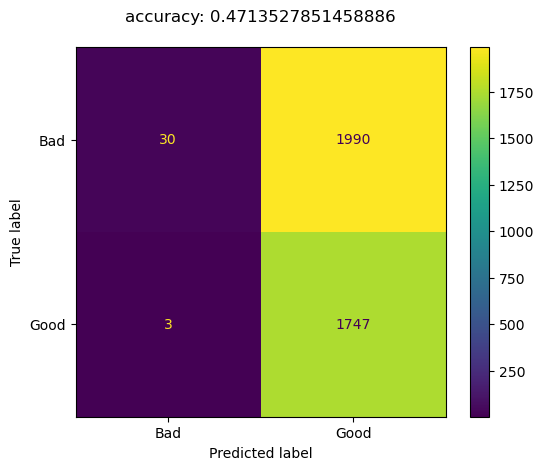

In [58]:
report = TestSVM(elden_ring_svm_Count, elden_ring_vectorizer_Count, game_spot_X_test, game_spot_y_test)
report = TestSVM(elden_ring_svm_TFID, elden_ring_vectorizer_TFID, game_spot_X_test, game_spot_y_test)
report = TestSVM(elden_ring_svm_Hashing, elden_ring_vectorizer_Hashing, game_spot_X_test, game_spot_y_test)

# Train SVM with Steam Data

In [26]:
steam_svm_Count, steam_vectorizer_Count = CreateSVMCount(steam_X_train, steam_y_train)
steam_svm_TFID, steam_vectorizer_TFID = CreateSVMTFID(steam_X_train, steam_y_train)
steam_svm_Hashing, steam_vectorizer_Hashing = CreateSVMHashing(steam_X_train, steam_y_train)

training SVM...


C:\Users\sadze\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Trained SVM in 1845.5112855434418 s
training SVM...
Trained SVM in 75.68680930137634 s
training SVM...
Trained SVM in 84.59930372238159 s


### Test steam_svm on steam data

Testing SVM ...
Tested SVM in 49.51412582397461 s
accuracy: 0.8830759758099702

Testing SVM ...
Tested SVM in 52.07455277442932 s
accuracy: 0.8899763435279605

Testing SVM ...
Tested SVM in 40.885846853256226 s
accuracy: 0.8896003569532295



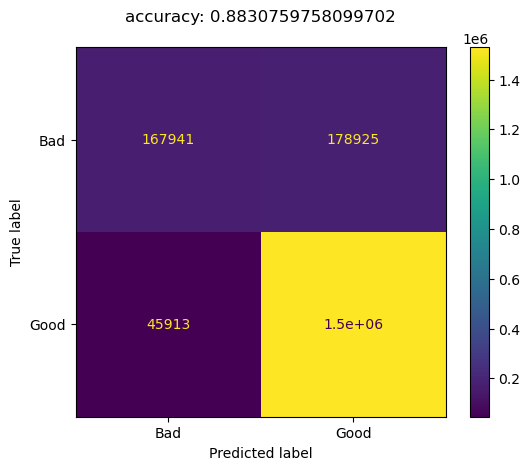

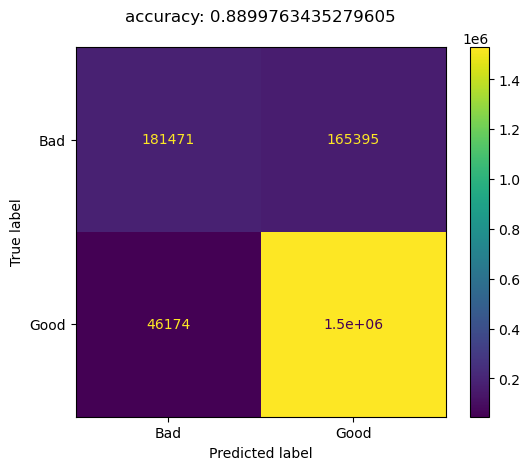

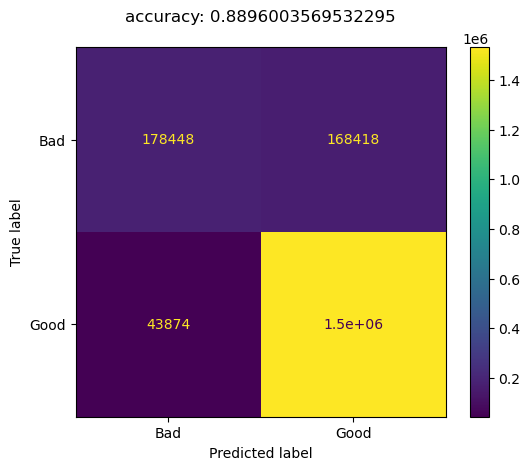

In [59]:
report = TestSVM(steam_svm_Count, steam_vectorizer_Count, steam_X_test, steam_y_test)
report = TestSVM(steam_svm_TFID, steam_vectorizer_TFID, steam_X_test, steam_y_test)
report = TestSVM(steam_svm_Hashing, steam_vectorizer_Hashing, steam_X_test, steam_y_test)

### Test steam_svm on game spot data

Testing SVM ...
Tested SVM in 2.00742769241333 s
accuracy: 0.6129973474801061

Testing SVM ...
Tested SVM in 2.0529448986053467 s
accuracy: 0.6129973474801061

Testing SVM ...
Tested SVM in 1.792748212814331 s
accuracy: 0.5347480106100796



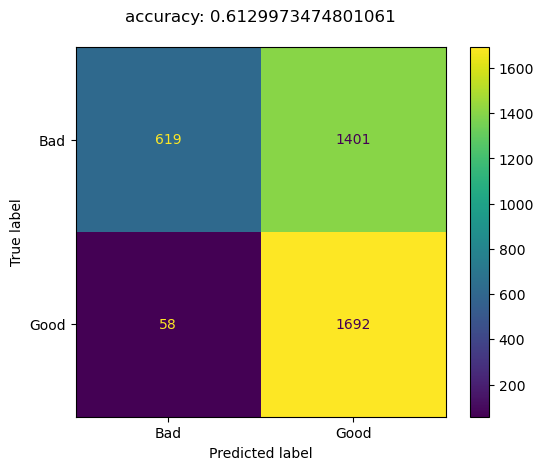

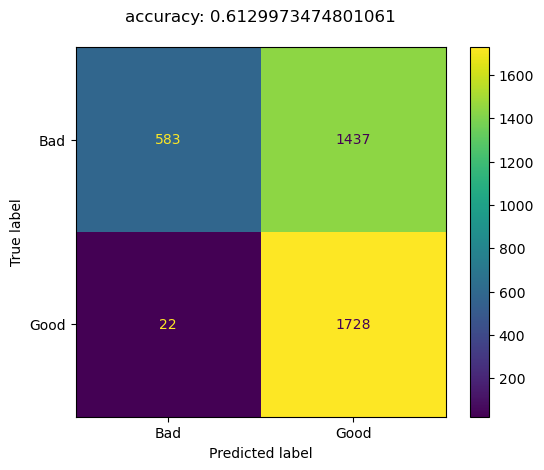

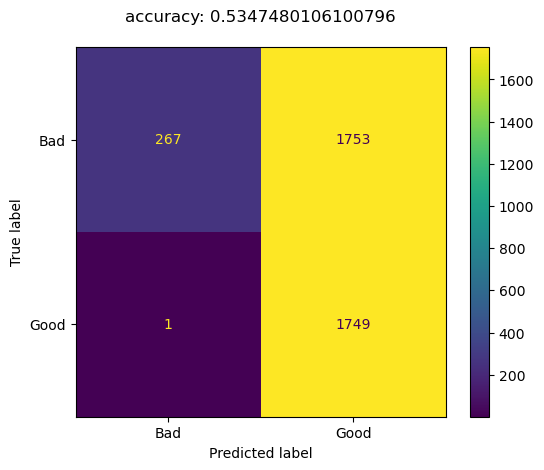

In [60]:
report = TestSVM(steam_svm_Count, steam_vectorizer_Count, game_spot_X_test, game_spot_y_test)
report = TestSVM(steam_svm_TFID, steam_vectorizer_TFID, game_spot_X_test, game_spot_y_test)
report = TestSVM(steam_svm_Hashing, steam_vectorizer_Hashing, game_spot_X_test, game_spot_y_test)

### Test steam_svm on elden ring data

Testing SVM ...
Tested SVM in 0.04205894470214844 s
accuracy: 0.9494880546075085

Testing SVM ...
Tested SVM in 0.04156756401062012 s
accuracy: 0.9464163822525598

Testing SVM ...
Tested SVM in 0.03399968147277832 s
accuracy: 0.942320819112628



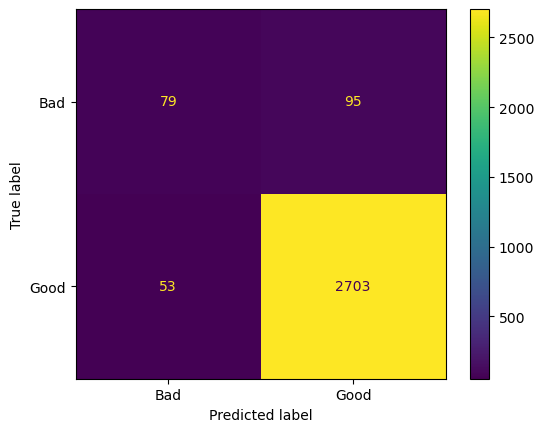

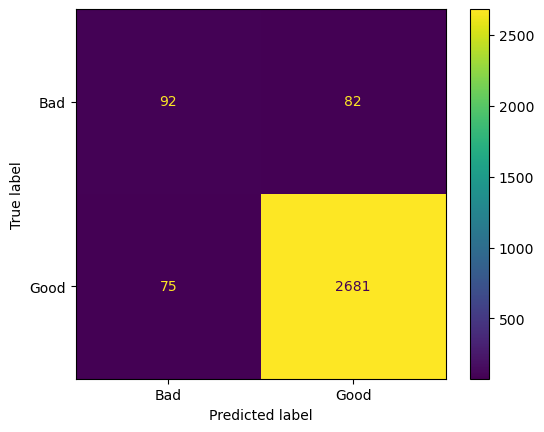

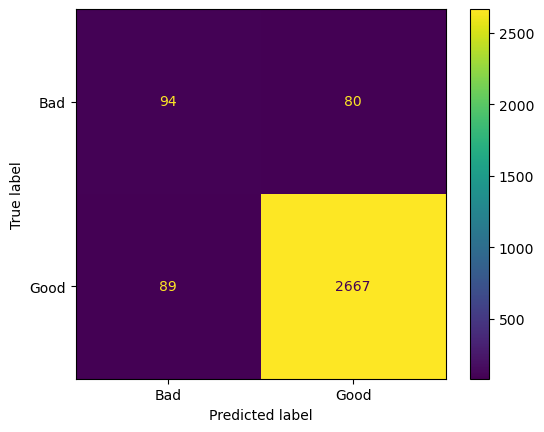

In [42]:
report = TestSVM(steam_svm_Count, steam_vectorizer_Count, elden_ring_X_test, elden_ring_y_test)
report = TestSVM(steam_svm_TFID, steam_vectorizer_TFID, elden_ring_X_test, elden_ring_y_test)
report = TestSVM(steam_svm_Hashing, steam_vectorizer_Hashing, elden_ring_X_test, elden_ring_y_test)